In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import geopandas as gpd
import fiona

# !pip install pyogrio
# import pyogrio

from shapely.geometry import Point, Polygon
import seaborn as sns

from sklearn.cluster import KMeans
import math
import csv

from pandas.api.types import is_numeric_dtype

from sklearn.model_selection import train_test_split
!pip install catboost

from catboost import CatBoostRegressor, Pool
import catboost as cb
from sklearn.metrics import mean_squared_error

# Load Data and Preprocess

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
barcelona_df = pd.read_csv("/content/drive/MyDrive/AIT Classes/Data Science/Project/chicago_listings.csv")
barcelona_df = barcelona_df.dropna(subset=['price'])

In [15]:
# convert price to float
price_list = []
for price in barcelona_df['price']:
    cleaned = (price).replace(',', '')
    price_list.append(float(cleaned[1:]))

barcelona_df['price_float'] = price_list

In [18]:
print(barcelona_df.shape)
barcelona_df = barcelona_df[barcelona_df['price_float'] <= 500.0]
print(barcelona_df.shape)

(8031, 76)
(8031, 76)


# Feature Extraction: Distance to City Center

In [19]:
# load Barcelona Map
street_map = gpd.read_file('/content/drive/MyDrive/AIT Classes/Data Science/Project/chicago.shp')

In [20]:
# Plot the listings in the map
geometry = [Point(xy) for xy in zip(barcelona_df['longitude'], barcelona_df['latitude'])]
geo_df = gpd.GeoDataFrame(barcelona_df, geometry=geometry) #specify the geometry list we created

Text(0.5, 1.0, 'Loacations of the listing across the city')

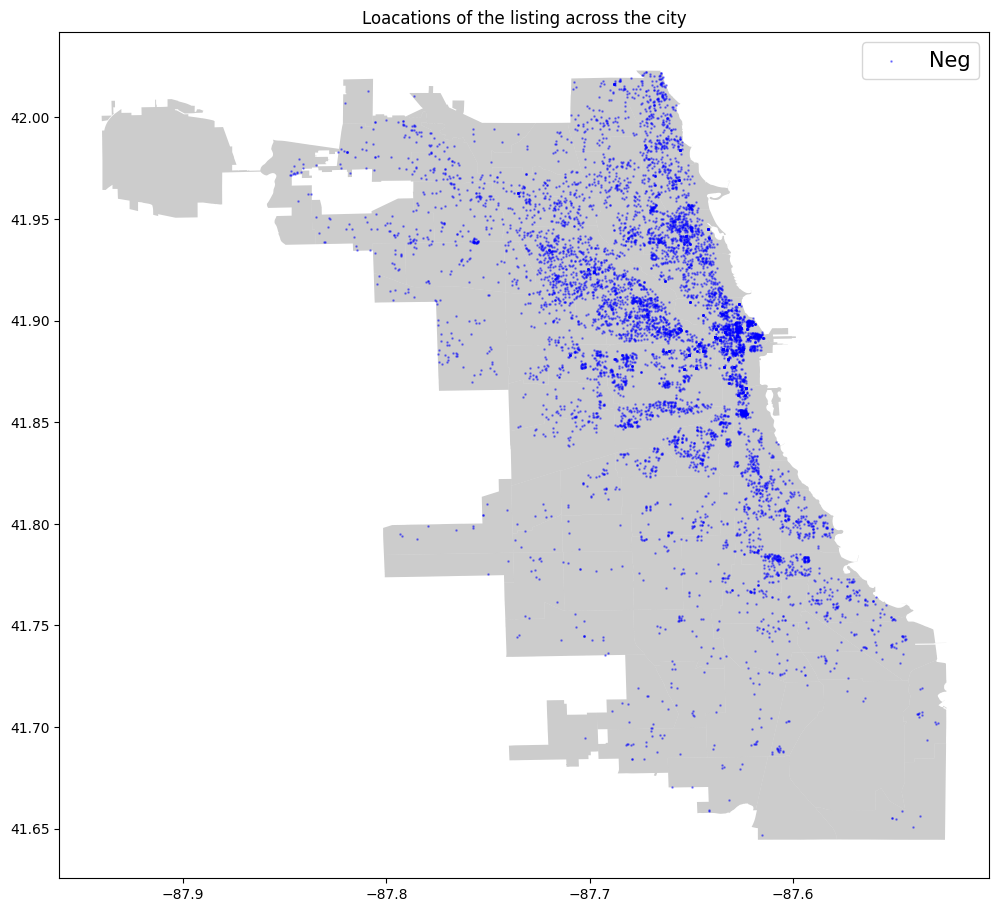

In [21]:
fig, ax = plt.subplots(figsize=(12,12))
street_map.plot(ax=ax, alpha=0.4, color='grey')

geo_df.plot(ax=ax, markersize=3, color='blue', marker='.', label='Neg', alpha=0.4)
plt.legend(prop={'size':15})
plt.title('Loacations of the listing across the city')

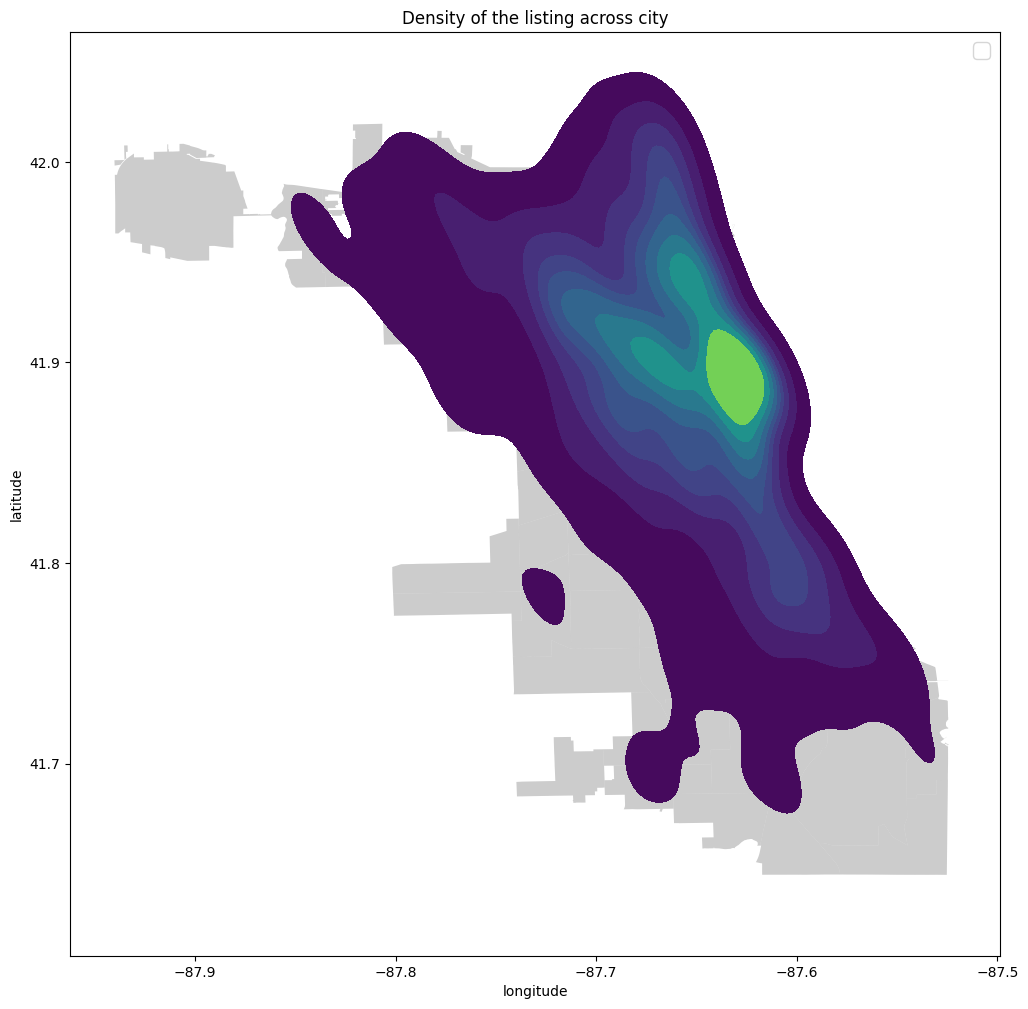

In [22]:
# Density of the listing across city
fig, ax = plt.subplots(figsize=(12,12))
street_map.plot(ax=ax, alpha=0.4, color='grey')

kde = sns.kdeplot(data=geo_df, x='longitude', y='latitude', fill=True, cmap='viridis', ax=ax, thresh=0.025)#.0025
# cbar = plt.colorbar(kde.collections[0], ax=ax, label='Density')
plt.title('Density of the listing across city')
plt.legend(prop={'size':15})

In [27]:
# Kmeans clustering
coordinates = barcelona_df[['latitude', 'longitude']]

num_clusters = 3
kmean_cluster = KMeans(n_clusters=num_clusters, random_state=42)
barcelona_df['cluster'] = kmean_cluster.fit_predict(coordinates)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


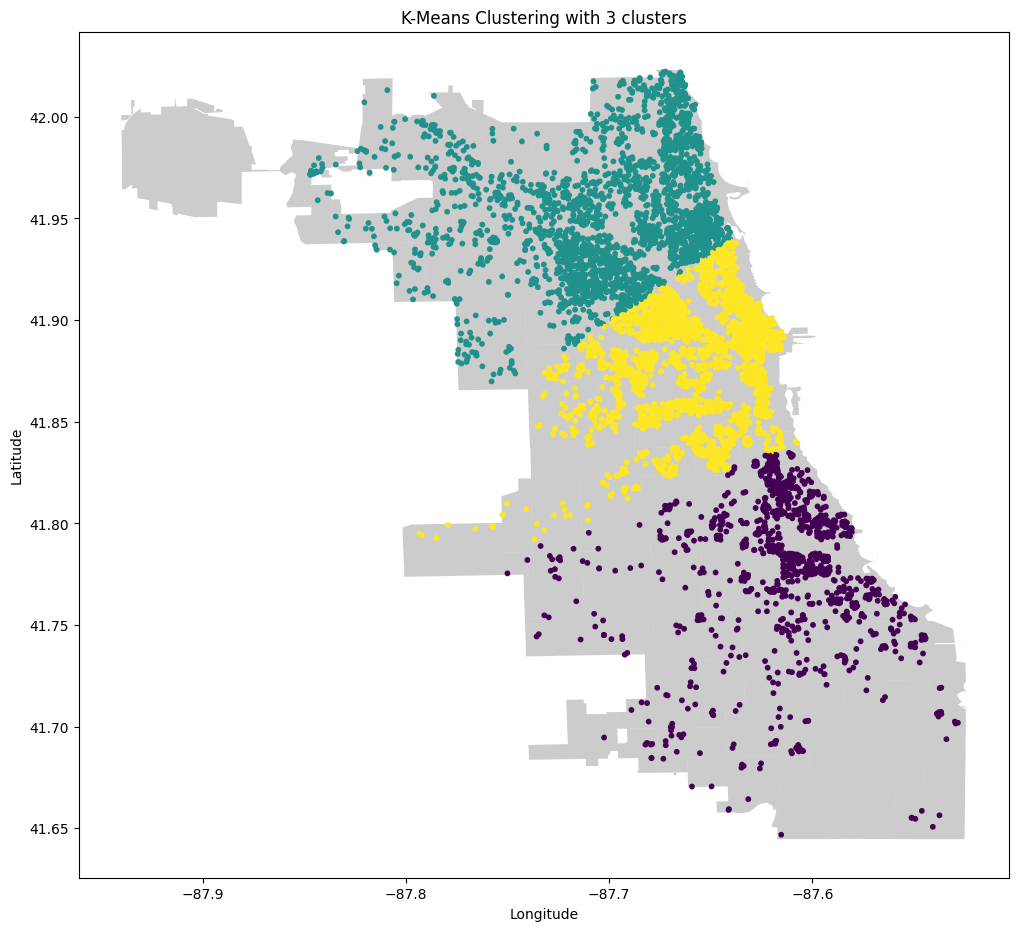

In [28]:
fig, ax = plt.subplots(figsize=(12,12))
street_map.plot(ax=ax, alpha=0.4, color='grey')
plt.scatter(barcelona_df['longitude'], barcelona_df['latitude'], c=barcelona_df['cluster'], cmap='viridis', s=10)
plt.title(f'K-Means Clustering with {num_clusters} clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [29]:
densest_cluster = np.argmax(np.bincount(barcelona_df['cluster']))
densest_cluster_lat_longs = coordinates[barcelona_df['cluster'] == densest_cluster]
centroid = [np.mean(densest_cluster_lat_longs['latitude']), np.mean(densest_cluster_lat_longs['longitude'])] # [latitude, longitude]
print(f"Coordinates of the densest spot (centroid of the densest cluster): {centroid}")

Coordinates of the densest spot (centroid of the densest cluster): [41.88218647326755, -87.65137221557939]


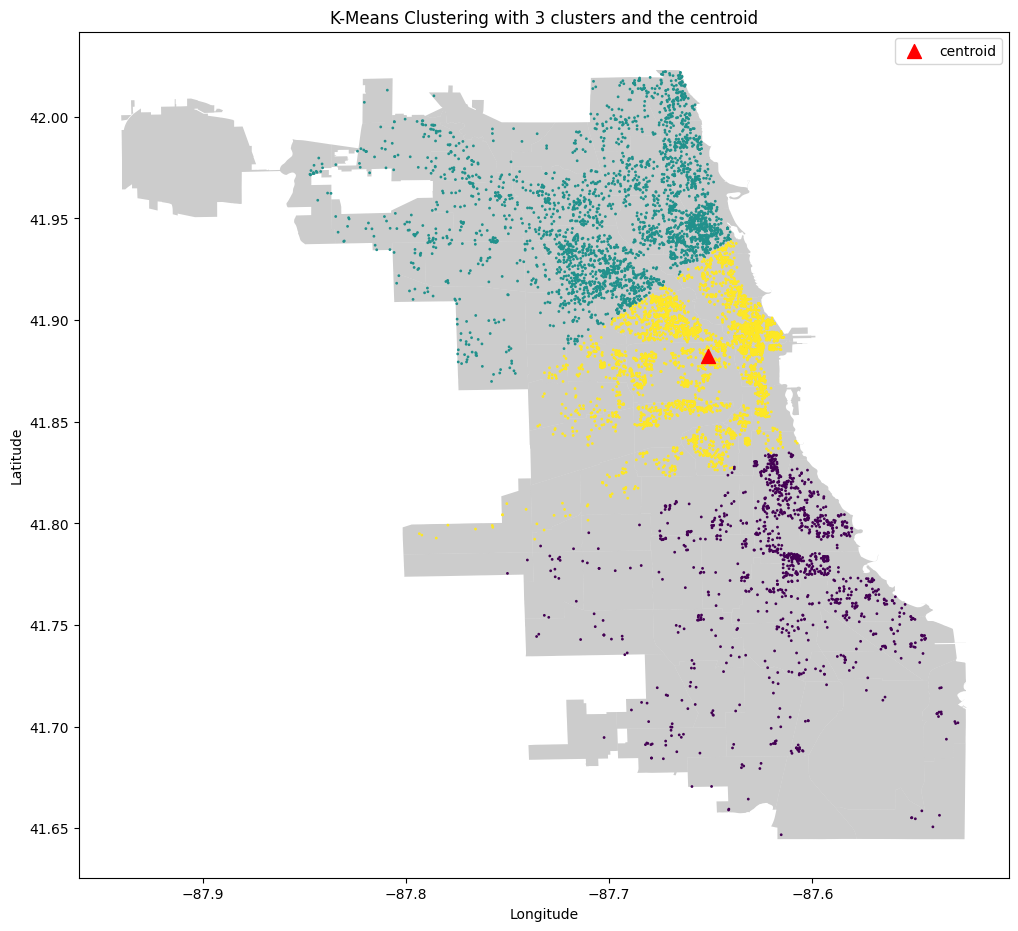

In [30]:
fig, ax = plt.subplots(figsize=(12,12))
street_map.plot(ax=ax, alpha=0.4, color='grey')
plt.scatter(barcelona_df['longitude'], barcelona_df['latitude'], c=barcelona_df['cluster'], cmap='viridis', s=1)
plt.scatter(centroid[1], centroid[0], c = 'red', marker='^', s = 100, label = 'centroid')
plt.title(f'K-Means Clustering with {num_clusters} clusters and the centroid')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

In [31]:
print(centroid)

[41.88218647326755, -87.65137221557939]


In [32]:
# adding distance to city center to the dataframe
dist_to_cen = []
for i in range(len(barcelona_df)):
    dist_to_cen.append(math.dist(centroid, [barcelona_df.iloc[i][30], barcelona_df.iloc[i][31]]))

print(min(dist_to_cen))
print(dist_to_cen)
barcelona_df['to_city_center'] = dist_to_cen

0.0006612260664265056
[0.13921566541957586, 0.032308524506198484, 0.16791460858291066, 0.11371616259311801, 0.02852249547880642, 0.03479706961353657, 0.03193975145789452, 0.13220717970161963, 0.053316939596480394, 0.041427221834508046, 0.04677205492674191, 0.0440582240036037, 0.043024785714655976, 0.048129278212061935, 0.16013391790396977, 0.03125983116086032, 0.03607643284418315, 0.09837884308594319, 0.052328046002286986, 0.0681163576185958, 0.03323877054540448, 0.06921588523000845, 0.04540824636857226, 0.06534345001827481, 0.19874564024593294, 0.11653988268203332, 0.19749930776347566, 0.19804401785361708, 0.06344914830366051, 0.10685916528969475, 0.10013822853832814, 0.03729479858572049, 0.12921877437279014, 0.05112555687737897, 0.008448794304132146, 0.08567642359132578, 0.09602479549095806, 0.05420129308918292, 0.05613726860987135, 0.056082405755990196, 0.11065767450580781, 0.09362957539196788, 0.04141744268612705, 0.07327947101062755, 0.058990308481533485, 0.052670734992125455, 0.0

# dropping useless features

In [33]:
# insights about barcelona_df: bathrooms has only NaNs, create categoricals into strings, feature extraction on amenities,
not_useful = ['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_location',
            'host_thumbnail_url', 'host_picture_url', 'host_verifications', 'neighbourhood', 'bathrooms', 'price', 'calendar_updated',
             'calendar_last_scraped', 'first_review', 'last_review', 'license', 'cluster' ]

# dropped for now / for this project
might_be_useful = ['name', 'description', 'neighborhood_overview', 'host_about' ]

# host_since: date handling, host_response_time = categorical integration possible, host_neighbourhood: have to see if whether useful or not
# amenities: feature extraction possible,
flagged_col = ['host_since', 'host_response_time', 'host_neighbourhood', 'latitude', 'longitude', 'amenities', ]

# host_response_rate, host_acceptance_rate: format %, host_has_profile_pic: format datatype('0'), property_type: drop low frequency unique values
to_format = ['host_response_rate', 'host_acceptance_rate', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_cleansed','neighbourhood_group_cleansed',
            'property_type', 'room_type', 'accommodates', 'bathrooms_text', 'has_availability', 'instant_bookable',  ]

TO_DROP = not_useful + might_be_useful + flagged_col + to_format

integrated_directly = ['host_is_superhost', 'host_listings_count', 'host_total_listings_count', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights',
                      'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm',
                      'maximum_nights_avg_ntm', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
                      'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                      'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
                      'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month', 'price_float', 'to_city_center']

print(len(not_useful) + len(might_be_useful) + len(flagged_col) + len(to_format) + len(integrated_directly))
print(len(barcelona_df.columns))
print(barcelona_df.columns[len(not_useful) + len(might_be_useful) + len(flagged_col) + len(to_format) + len(integrated_directly)-1])

78
78
to_city_center


In [34]:
pre_filtered_barcelona_df = barcelona_df.drop(columns=(not_useful + might_be_useful + flagged_col), axis=1)

print(pre_filtered_barcelona_df.shape)
pre_filtered_barcelona_df.head()

(8031, 46)


,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,...,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price_float,to_city_center
0,100%,95%,f,15,22,t,t,West Ridge,NaN,Shared room in rental unit,...,4.52,4.65,f,15,0,4,11,1.49,28.0,0.139216
1,100%,94%,t,7,85,t,t,Lincoln Park,NaN,Entire rental unit,...,4.97,4.77,t,5,5,0,0,0.88,146.0,0.032309
2,100%,96%,t,2,2,t,t,Beverly,NaN,Private room in bungalow,...,4.79,4.87,f,2,0,2,0,1.59,49.0,0.167915
3,100%,92%,t,1,1,t,t,Hyde Park,NaN,Private room in condo,...,4.96,4.94,f,1,0,1,0,2.10,70.0,0.113716
5,100%,100%,t,2,2,t,t,Lower West Side,NaN,Private room in home,...,4.89,4.88,f,2,0,2,0,5.02,48.0,0.028522


# fix/convert some useful attributes

In [35]:
# response rate and acceptance rate
resp_rate = []
accept_rate = []

for r_rate in pre_filtered_barcelona_df['host_response_rate']:
  r = str(r_rate)
  if (r == 'nan'):
    resp_rate.append(int(0))
  else:
    resp_rate.append(int(r[:-1]))

for a_rate in pre_filtered_barcelona_df['host_acceptance_rate']:
  a = str(a_rate)
  if (a == 'nan'):
    accept_rate.append(int(0))
  else:
    accept_rate.append(int(a[:-1]))

pre_filtered_barcelona_df['host_response_rate'] = resp_rate
pre_filtered_barcelona_df['host_acceptance_rate'] = accept_rate

print(pre_filtered_barcelona_df.shape)

(8031, 46)


In [36]:
def to_binary_encoding(df, name):
  tracker = []
  for val in df[name]:
    if (str(val) == 't'):
      tracker.append(int(1))
    else:
      tracker.append(int(0))
  return tracker

formatted = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'has_availability', 'instant_bookable']
for fr in formatted:
  pre_filtered_barcelona_df[f'{fr}_formatted'] = to_binary_encoding(pre_filtered_barcelona_df, fr)
pre_filtered_barcelona_df.drop(columns=formatted, inplace=True)

In [37]:
pre_filtered_barcelona_df.head()

,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms_text,...,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price_float,to_city_center,host_is_superhost_formatted,host_has_profile_pic_formatted,host_identity_verified_formatted,has_availability_formatted,instant_bookable_formatted
0,100,95,15,22,West Ridge,NaN,Shared room in rental unit,Shared room,1,2 shared baths,...,4,11,1.49,28.0,0.139216,0,1,1,1,0
1,100,94,7,85,Lincoln Park,NaN,Entire rental unit,Entire home/apt,4,1 bath,...,0,0,0.88,146.0,0.032309,1,1,1,1,1
2,100,96,2,2,Beverly,NaN,Private room in bungalow,Private room,2,1.5 shared baths,...,2,0,1.59,49.0,0.167915,1,1,1,1,0
3,100,92,1,1,Hyde Park,NaN,Private room in condo,Private room,1,1 shared bath,...,1,0,2.10,70.0,0.113716,1,1,1,1,0
5,100,100,2,2,Lower West Side,NaN,Private room in home,Private room,4,1 shared bath,...,2,0,5.02,48.0,0.028522,1,1,1,1,0


In [38]:
def get_categorical_indicies(X):
    cats = []
    for col in X.columns:
        if is_numeric_dtype(X[col]):
            pass
        else:
            cats.append(col)
    cat_indicies = []
    for col in cats:
        cat_indicies.append(X.columns.get_loc(col))
    return cat_indicies

categorical_indicies = get_categorical_indicies(pre_filtered_barcelona_df)
print(categorical_indicies)

[4, 6, 7, 9]


In [39]:
cat_names = []
for cat_i in categorical_indicies:
  print(pre_filtered_barcelona_df.columns[cat_i])
  cat_names.append(pre_filtered_barcelona_df.columns[cat_i])

print(' ====> dimension before dropping: ', pre_filtered_barcelona_df.shape)
pre_filtered_barcelona_df.drop(columns=cat_names, inplace=True)
print(' ====> dimension after droppnig: ', pre_filtered_barcelona_df.shape)

neighbourhood_cleansed
property_type
room_type
bathrooms_text
 ====> dimension before dropping:  (8031, 46)
 ====> dimension after droppnig:  (8031, 42)


In [40]:
col_used = pre_filtered_barcelona_df.columns
with open('/content/sample_data/columns_used.txt', 'w') as file:
  for i, col in enumerate(col_used):
    file.write(f'{i+1}: {col}\n')

In [41]:
print(pre_filtered_barcelona_df.shape)

(8031, 42)


# Train Model

In [42]:
y = pre_filtered_barcelona_df['price_float']
pre_filtered_barcelona_df = pre_filtered_barcelona_df.drop(columns='price_float',axis=1)
X = pre_filtered_barcelona_df

In [43]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create CatBoost Pools for training, validation, and test sets
train_pool = cb.Pool(X_train, label=y_train)
val_pool = cb.Pool(X_val, label=y_val)
test_pool = cb.Pool(X_test, label=y_test)

# Create a CatBoostRegressor
catboost_regressor = CatBoostRegressor(iterations=300, depth=7, learning_rate=0.1, loss_function='RMSE', random_seed=42)

# Train the model using the training Pool and validate on the validation set
catboost_regressor.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100, verbose=10)

# Make predictions on the test set
y_pred = catboost_regressor.predict(test_pool)

0:	learn: 86.5150344	test: 82.1762615	best: 82.1762615 (0)	total: 71.4ms	remaining: 21.3s
10:	learn: 68.5464607	test: 66.7620860	best: 66.7620860 (10)	total: 262ms	remaining: 6.89s
20:	learn: 61.7564350	test: 61.4595759	best: 61.4595759 (20)	total: 429ms	remaining: 5.7s
30:	learn: 58.4546509	test: 59.3303531	best: 59.3303531 (30)	total: 689ms	remaining: 5.98s
40:	learn: 56.1942719	test: 57.8583997	best: 57.8583997 (40)	total: 1.38s	remaining: 8.7s
50:	learn: 54.6522717	test: 57.0711475	best: 57.0711475 (50)	total: 1.99s	remaining: 9.73s
60:	learn: 52.9777357	test: 55.9398954	best: 55.9398954 (60)	total: 2.29s	remaining: 8.98s
70:	learn: 51.9601255	test: 55.5063767	best: 55.5063767 (70)	total: 2.47s	remaining: 7.97s
80:	learn: 50.8200865	test: 55.0145219	best: 55.0145219 (80)	total: 2.66s	remaining: 7.19s
90:	learn: 49.7466810	test: 54.7446399	best: 54.7446399 (90)	total: 2.88s	remaining: 6.61s
100:	learn: 48.6992654	test: 54.4221077	best: 54.4221077 (100)	total: 3.05s	remaining: 6.01s


In [44]:
print(len(pre_filtered_barcelona_df.columns))

41


# Save dataframe with overpricing and prediction data


In [45]:
y_pred_all = catboost_regressor.predict(pre_filtered_barcelona_df)

# Add the predictions as a new column named 'prediction' to pre_filtered_barcelona_df
pre_filtered_barcelona_df['prediction'] = y_pred_all

# logging overpriced/underpriced (1 for overpriced and 0 for underpriced)
pre_filtered_barcelona_df['price_float'] = y

pre_filtered_barcelona_df['overpriced'] = np.where(pre_filtered_barcelona_df['price_float'] > pre_filtered_barcelona_df['prediction'], 1, 0)

pre_filtered_barcelona_df['latitude'] = barcelona_df['latitude']
pre_filtered_barcelona_df['longitude'] = barcelona_df['longitude']

pre_filtered_barcelona_df.to_csv('/content/drive/MyDrive/AIT Classes/Data Science/Project/predictions/chicago_listing_and_predictions.csv', index=False)

In [46]:
pre_filtered_barcelona_df['overpriced']


0       1
1       0
2       0
3       0
5       0
       ..
8944    0
8945    1
8946    0
8947    1
8948    0
Name: overpriced, Length: 8031, dtype: int64

# Evalutaion

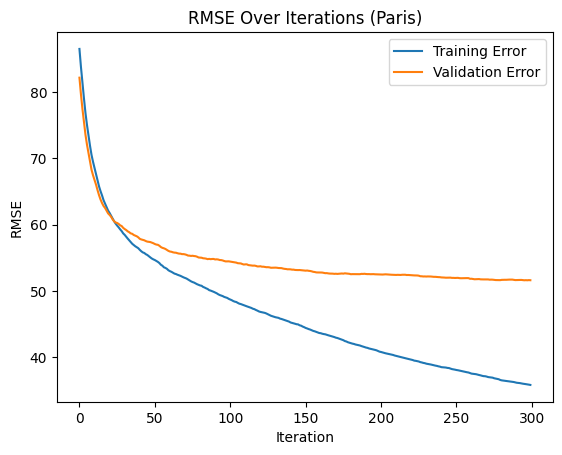

In [47]:
iterations = range(len(catboost_regressor.get_evals_result()['learn']['RMSE']))

plt.plot(iterations, catboost_regressor.get_evals_result()['learn']['RMSE'], label='Training Error')
plt.plot(iterations, catboost_regressor.get_evals_result()['validation']['RMSE'], label='Validation Error')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('RMSE Over Iterations (Paris)')
plt.legend()
plt.show()

In [48]:
feature_importance = catboost_regressor.get_feature_importance()
print(feature_importance)

[ 2.30353811  2.60490424  3.16942785  4.84581379  0.         21.74836694
  0.          6.4774735   1.57468442  1.80734379  0.57249045  1.60501211
  2.14567935  0.58711238  1.36596052  0.69880621  0.77415281  1.45325924
  0.83832307  2.67236715  2.93886683  1.78838342  1.21631882  1.98064024
  1.64115614  2.15492956  0.75595804  0.7069754   4.20813217  1.65087292
  3.14870048  3.06179621  3.8084407   0.08622258  4.80829368  6.83749974
  0.56527318  0.36604357  0.25265135  0.          0.77812902]


In [49]:
print(len(feature_importance))
print(len(X.columns))

41
46


Text(0.5, 1.0, 'Feature Importance in the Model (Paris)')

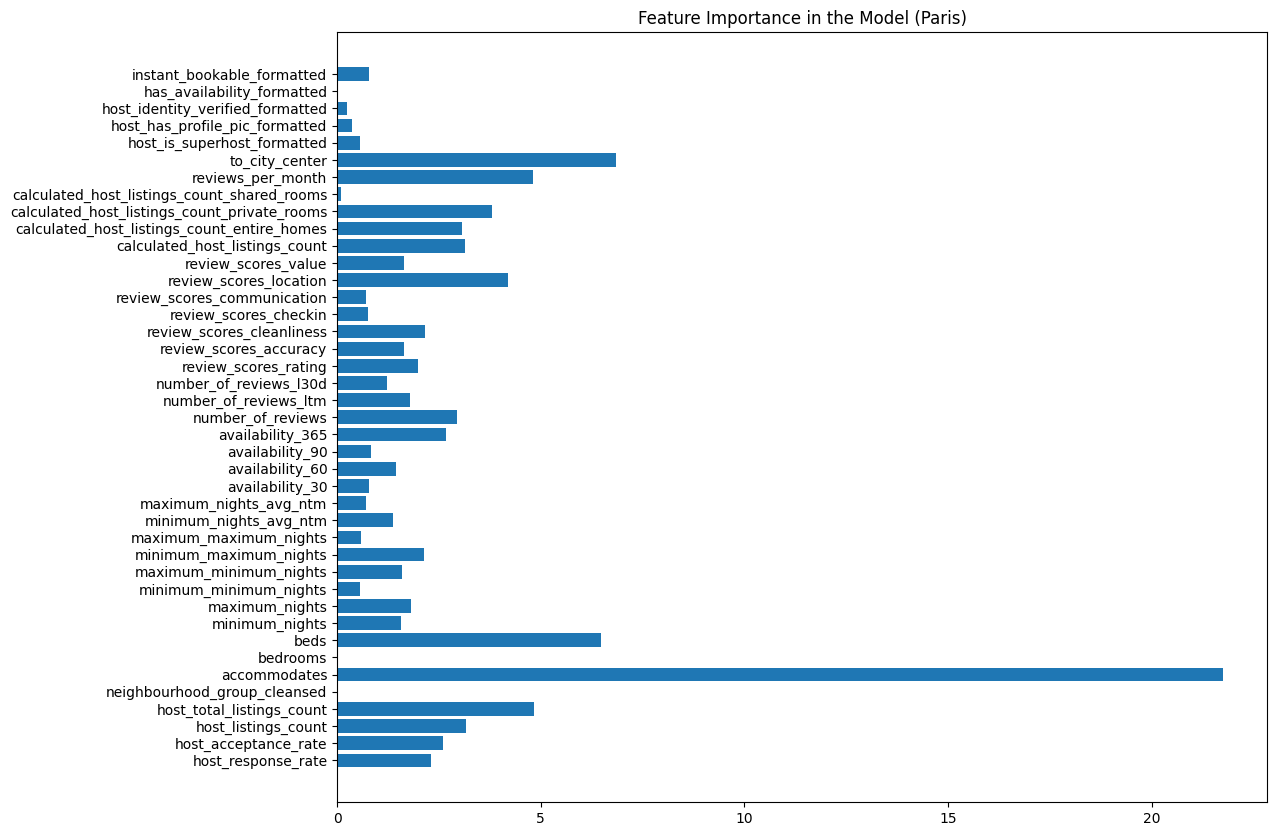

In [50]:
plt.figure(figsize=(12,10))
plt.barh([i for i in X.columns][:41], feature_importance)
plt.title("Feature Importance in the Model (Paris)")

# Save Feature Importance

In [56]:
# create a dict containig feature importance
feature_importance_zipped = zip([i for i in X.columns], feature_importance)
sorted_feature_importance = sorted(feature_importance_zipped, key=lambda x: x[1], reverse=True)

csv_file = '/content/drive/MyDrive/AIT Classes/Data Science/Project/feature_importance/chicago_feature_importance.csv'
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Key', 'Value'])
    for i in sorted_feature_importance:
      to_write = [i[0], i[1]]
      writer.writerow(to_write)

Text(0.5, 1.0, 'Performance of prediction set against test set')

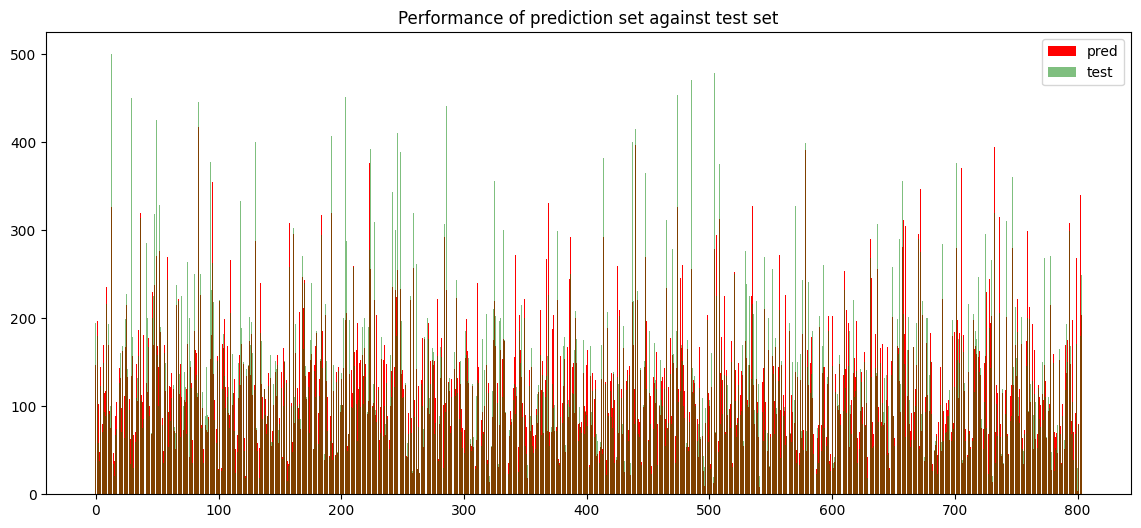

In [51]:
plt.figure(figsize=(14,6))
plt.bar([i for i in range(len(y_pred))], y_pred, color='red', label='pred')
plt.bar([i for i in range(len(y_test))], y_test, color='green', alpha=.5, label='test')
plt.legend()
plt.title('Performance of prediction set against test set')

Text(0.5, 1.0, 'Absolute error for each listing in test set')

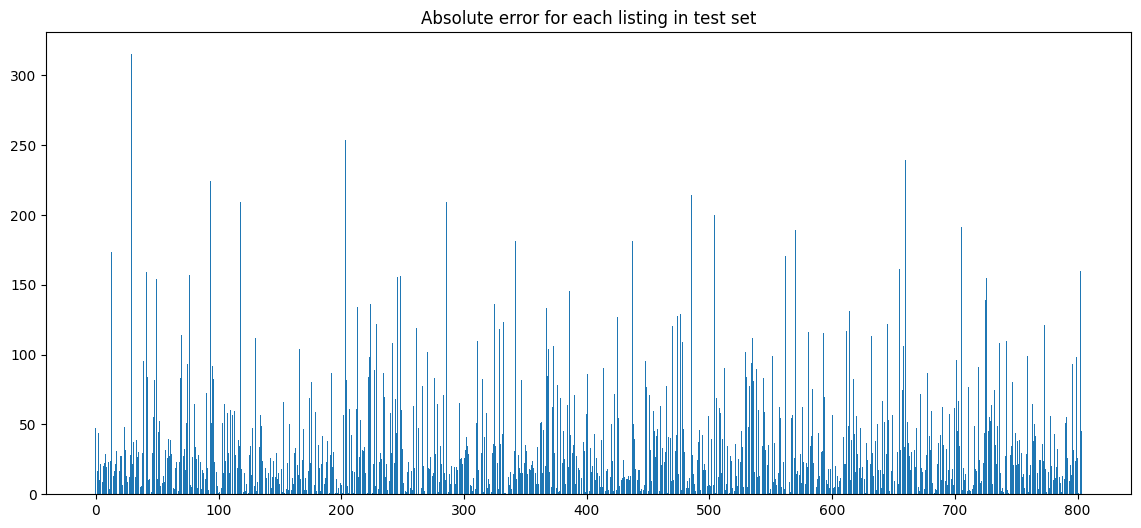

In [52]:
crude_error = []
y_t = y_test.tolist()
y_p = y_pred.tolist()
for i in range(len(y_t)):
  crude_error.append(abs(y_t[i] - y_p[i]))

plt.figure(figsize=(14,6))
plt.bar([i for i in range(len(y_t))], crude_error)
plt.title('Absolute error for each listing in test set')

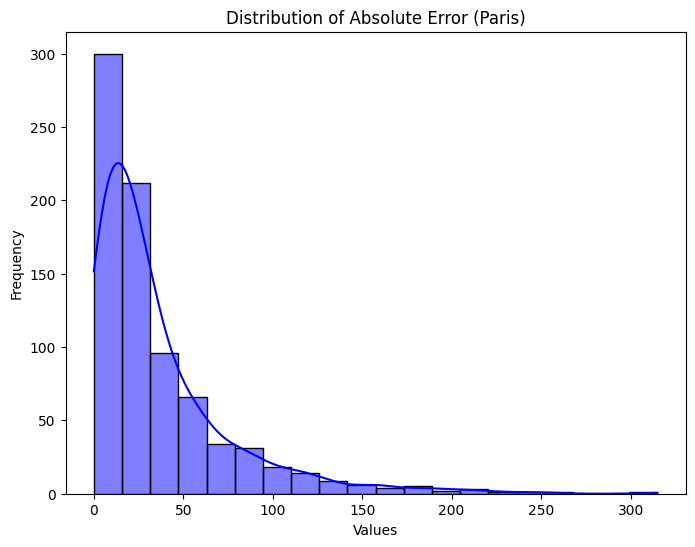

In [53]:
plt.figure(figsize=(8,6))
sns.histplot(crude_error, bins=20, kde=True, color='blue', edgecolor='black')
plt.title('Distribution of Absolute Error (Paris)')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()